In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
#import tensorflow

In [13]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Imbalanced Data Handling
# from imblearn.over_sampling import SMOTE

# Deep Learning Libraries
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout

In [ ]:
#import tensorflow as tf
#print("TensorFlow version:", tf.__version__)
#print("GPU Available:", tf.config.list_physical_devices('GPU'))

Loading EEG data...
Classifying attention states...
Training and evaluating models on all data...
Applying SMOTE for class balancing...
Starting Logistic Regression training...
Logistic Regression training completed.

Logistic Regression Classification Report:

              precision    recall  f1-score   support

      drowsy       0.90      0.58      0.71      1818
     focused       0.37      0.72      0.49       319
   unfocused       0.27      0.54      0.36       320

    accuracy                           0.60      2457
   macro avg       0.51      0.62      0.52      2457
weighted avg       0.75      0.60      0.63      2457

Starting k-NN training...
k-NN training completed.

k-NN Classification Report:

              precision    recall  f1-score   support

      drowsy       0.82      0.99      0.89      1818
     focused       0.82      0.47      0.59       319
   unfocused       0.58      0.12      0.19       320

    accuracy                           0.81      2457
   m

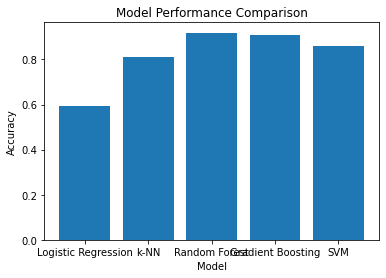

Model performance comparison saved as 'model_performance_comparison.png'.


In [14]:
'''
import scipy.io
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from joblib import Parallel, delayed
'''

'''
# Install necessary libraries (useful for Colab or local setup)
try:
    import imblearn
except ImportError:
    !pip install imbalanced-learn

try:
    import tensorflow
except ImportError:
    !pip install tensorflow
'''

# Constants

DATA_PATH = '/Users/lukeyang/Downloads/Theo_BCI/data'  # Update to your data folder path
CHANNEL_NAMES = [
    'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2',
    'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'Marker1', 'Marker2'
]
SAMPLING_FREQUENCY = 128  # Hz
FOCUSED_END = 10 * 60 * SAMPLING_FREQUENCY
UNFOCUSED_END = 20 * 60 * SAMPLING_FREQUENCY
DROWSY_END = 30 * 60 * SAMPLING_FREQUENCY

# Function to load and preprocess all .mat files
def load_eeg_data(data_path):
    files = [f for f in os.listdir(data_path) if f.endswith('.mat')]
    all_data = []
    for file in files:
        mat = scipy.io.loadmat(os.path.join(data_path, file))
        raw_data = mat['o']['data'][0, 0]
        eeg_df = pd.DataFrame(raw_data[:, :len(CHANNEL_NAMES)], columns=CHANNEL_NAMES)
        eeg_df['Time (s)'] = np.arange(0, raw_data.shape[0]) / SAMPLING_FREQUENCY
        all_data.append(eeg_df)
    return pd.concat(all_data, ignore_index=True)

# Function to classify attention states
def classify_attention_states(eeg_df):
    eeg_df.loc[:DROWSY_END, 'Attention_State'] = 'drowsy'
    eeg_df.loc[:FOCUSED_END, 'Attention_State'] = 'focused'
    eeg_df.loc[FOCUSED_END:UNFOCUSED_END, 'Attention_State'] = 'unfocused'
    
    # drop all data after DROWSY_END
    eeg_df = eeg_df.iloc[:DROWSY_END]
    
    eeg_df_300 = eeg_df.iloc[::50] #************* NOTE: THIS IS WHERE YOU CONTROL THE FRACTION OF DATA USED IN THE MODELS**********
    
    return eeg_df_300

def smote(X, y, minority_class, k_neighbors=5):
    X_minority = X[y == minority_class]
    nn = NearestNeighbors(n_neighbors=k_neighbors)
    nn.fit(X_minority)
    indices = nn.kneighbors(X_minority, return_distance=False)
    synthetic_samples = []

    for i in range(len(X_minority)):
        neighbors = indices[i]
        for neighbor in neighbors:
            diff = X_minority[neighbor] - X_minority[i]
            synthetic_sample = X_minority[i] + np.random.rand() * diff
            synthetic_samples.append(synthetic_sample)

    synthetic_samples = np.array(synthetic_samples)
    X_synthetic = np.vstack([X, synthetic_samples])
    y_synthetic = np.hstack([y, np.full(len(synthetic_samples), minority_class)])
    return X_synthetic, y_synthetic


# Function to create and train a neural network model
def train_neural_network(X_train, y_train, X_test, y_test):
    # Convert labels to one-hot encoding
    y_train_oh = pd.get_dummies(y_train)
    y_test_oh = pd.get_dummies(y_test)

    # Define the neural network model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(y_train_oh.shape[1], activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train_oh, epochs=10, batch_size=128, verbose=1, validation_split=0.2)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test_oh, verbose=0)
    return accuracy

# Function to train and evaluate a single model
def train_and_evaluate_single_model(model_name, model, X_train, X_test, y_train, y_test):
    print(f"Starting {model_name} training...")
    model.fit(X_train, y_train)
    print(f"{model_name} training completed.")

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

    return model_name, accuracy

# Function to train and evaluate machine learning models in sequential order
def train_and_evaluate_models(eeg_df):
    X = eeg_df.drop(['Attention_State', 'Time (s)'], axis=1)
    y = eeg_df['Attention_State']

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Handle class imbalance using SMOTE
    print("Applying SMOTE for class balancing...")
    #smote = SMOTE(random_state=42)
    #X, y = smote.fit_resample(X, y)
    X, y = smote(X, y, minority_class='drowsy')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = [
        ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')),
        ('k-NN', KNeighborsClassifier(n_neighbors=20)),
        ('Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
    ]

    results = []

    for model_name, model in models:
        name, accuracy = train_and_evaluate_single_model(model_name, model, X_train, X_test, y_train, y_test)
        results.append((name, accuracy))

    # Train SVM on all data
    print("Starting SVM training on all data...")
    
    # Parameter grid
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 0.01, 0.1]
    }
    
    #********** BELOW IS THE SVM CODE THAT WORKS WELL WITH CROSS VALIDATION; THE RED COMMENTS BELOW WORK BUT NOT AS WELL*************
    # Grid search
    svm = SVC(class_weight='balanced')
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_svm = grid_search.best_estimator_
    print("Best SVM Parameters:", grid_search.best_params_)
    
    # Evaluate on test data
    test_accuracy = best_svm.score(X_test, y_test)
    print(f"SVM Test Accuracy: {test_accuracy:.4f}")
    results.append(('SVM', test_accuracy))
    
    
    '''
    svm = SVC(kernel='linear', class_weight='balanced', tol=1e-3)
    svm.fit(X, y)
    svm_accuracy = accuracy_score(y, svm.predict(X))
    results.append(('SVM', svm_accuracy))
    print(f"SVM training completed with accuracy: {svm_accuracy:.4f}")
    '''

    '''
    # Train and evaluate the neural network
    print("Starting Neural Network training...")
    nn_accuracy = train_neural_network(X_train, y_train, X_test, y_test)
    results.append(('Neural Network', nn_accuracy))
    print(f"Neural Network training completed with accuracy: {nn_accuracy:.4f}")
    '''

    return dict(results)

# Function to plot model performance
def plot_model_performance(results):
    plt.bar(results.keys(), results.values())
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.savefig('model_performance_comparison.png')  # Save the plot for presentation
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Loading EEG data...")
    eeg_data = load_eeg_data(DATA_PATH)

    print("Classifying attention states...")
    eeg_data = classify_attention_states(eeg_data)

    print("Training and evaluating models on all data...")
    performance_results = train_and_evaluate_models(eeg_data)

    print("Plotting model performance...")
    plot_model_performance(performance_results)

    print("Model performance comparison saved as 'model_performance_comparison.png'.")
